# Evaluating the CNN model

### 1. Setup dependencies and style

In [1]:
import os
from pathlib2 import Path

import torch
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from src.models.test import test_model
from src.data.dataloader import get_loaders, get_loaders_with_concepts
from src.models.utils import set_seed, load_experiment
from src.data.process_dataset import get_meta

In [2]:
plt.style.use('ggplot')
sns.set(font_scale=1.0)
sns.set_style('darkgrid')

In [4]:
BASE_PATH               = Path("../..")
PROCESSED_DATA_PATH     = BASE_PATH / 'data/processed/CUB_200_2011'
RAW_DATA_PATH           = BASE_PATH / 'data/raw/CUB_200_2011'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
meta = get_meta(RAW_DATA_PATH / 'CUB_200_2011')

### 1. Load data

First, we define the arguments related to loading the dataset after which we construct the `DataLoader`s

In [4]:
# datafile_name = '03-24-2023-processed_data_224x224.pth'

# # Define arguments for loading
# args = {
#     'datafile': PROCESSED_DATA_PATH / datafile_name,
#     'batch_size': 64,
#     'num_workers': 1,
# }

# # Get dataset splits
# loaders, normalization = get_loaders(
#     data_path=args['datafile'],
#     batch_size=args['batch_size'], 
#     shuffle=True, 
#     num_workers=args['num_workers'],
# )

In [5]:
raw_datafolder_path = BASE_PATH / 'data/raw/CUB_200_2011'
processed_datafolder_path = BASE_PATH / 'data/processed/CUB_processed/class_attr_data_10'

loaders, normalization = get_loaders_with_concepts(
    raw_data_folder=raw_datafolder_path,
    processed_data_folder=processed_datafolder_path,
    batch_size=32,
)

INFO - Loading data...
INFO - training data loaded !
INFO - validation data loaded !
INFO - test data loaded !


### 2. Model performance on test set 

Next, we specify the experiment from which to load the saved model and load this model in evaluation mode...

In [6]:
experiment_checkpoint   = 'ResNet18-test-50epochs/best.ckpt'
experiment_checkpoint   = 'ResNet50-no_freeze-lr1e-4.wd1e-3.bz32.seed0/best.ckpt'

# Define experiment path
experiment_path = BASE_PATH / 'models' / experiment_checkpoint

# Load experiment stored from training
model_name, model, criterion = load_experiment(experiment_path, device=device)
model.eval()


INFO - LOADED EXPERIMENT: ResNet50-no_freeze-lr1e-4.wd1e-3.bz32.seed0
INFO -  model: {'name': 'ResNet50'}
INFO -  seed: 0
INFO -  best epoch: 24
INFO -  data: 
INFO -    filename: 
INFO -    normalization (mu, sigma): ([0.5, 0.5, 0.5], [2, 2, 2])



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Then, we are ready for evaluating the model on the test set !

In [7]:
# Run test
preds, probs, targets = test_model(
    loaders=loaders,
    model=model, 
    criterion=criterion,
    device=device,
)

INFO - using device: cuda


Predicting on test set...: 100%|██████████| 182/182 [00:24<00:00,  7.35it/s]

--------------------------------------------------------------------------------
PERFORMANCE ON TEST SET
--------------------------------------------------------------------------------
Avg. accuracy (with SEM) =  0.76441 +- 0.00558
--------------------------------------------------------------------------------


### 3. Define `GradCamModel`

The code is taken from here: https://medium.com/the-owl/gradcam-in-pytorch-7b700caa79e5 

In [8]:
import torch.nn as nn
from torchvision import transforms

from skimage.transform import resize

class GradCamModel(nn.Module):

    def __init__(self, model):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        
        #PRETRAINED MODEL
        self.pretrained = model
        self.layerhook.append(self.pretrained.layer4.register_forward_hook(self.forward_hook()))
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
    
    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out
    
gcmodel = GradCamModel(model=model).to('cuda:0')

### 3. Visualize saliency maps

Again, code is taken (however modified) from here: https://medium.com/the-owl/gradcam-in-pytorch-7b700caa79e5

In [13]:
def compute_saliency_map(gcmodel, batch, criterion, CAM_target='labels'):
    cmap = plt.get_cmap('jet')

    # To CUDA
    input_tensor = batch['image'].to(device)
    labels = batch['label'].to(device)
    idxs = batch['index']

    # Get outputs and activations
    out, acts = gcmodel(input_tensor)
    preds = torch.exp(out).topk(1)[1].flatten()
    
    acts = acts.detach().cpu()

    # Compute loss in terms of predictions and backtrack gradient
    if CAM_target == 'labels':
        loss = criterion(out, labels)
    elif CAM_target == 'predictions':
        loss = criterion(out, preds)
        
    loss.backward()

    # Get gradients of CAM layer
    grads = gcmodel.get_act_grads().detach().cpu()
    pooled_grads = torch.mean(grads, dim=[0, 2, 3]).detach().cpu()

    # Pool these
    for i in range(acts.shape[1]):
        acts[:,i,:,:] *= pooled_grads[i]

    heatmaps = {}
    for i, idx in enumerate(idxs):
        heatmap_j = torch.mean(acts[i, :, :, :].unsqueeze(0), dim = 1).squeeze()
        heatmap_j_max = heatmap_j.max(axis = 0)[0]
        heatmap_j /= heatmap_j_max

        heatmap_j = resize(heatmap_j.numpy(), (224,224), preserve_range=True)
        
        # Store
        heatmaps[idx] = cmap(heatmap_j)
        
    return heatmaps, preds

def visualize_saliency_maps(saliency_maps, batch, preds, normalization, CAM_target='labels', nrows=1, ncols=10, figsize=(8, 4)):

    # invNormalization = transforms.Compose([
    #     transforms.Normalize(mean=[ 0., 0., 0. ], std=1 / normalization['std']), 
    #     transforms.Normalize(mean=-normalization['mean'], std = [1., 1., 1.]),
    # ])
    
    # To CUDA
    input_tensor = batch['image']
    labels = batch['label']
    idxs = batch['index']
    
    fig, axs = plt.subplots(nrows, ncols, sharex=True, figsize=figsize)

    for i, (idx, s_map) in enumerate(saliency_maps.items()):
        # reverted_img = invNormalization(input_tensor[i]).permute(1, 2, 0).numpy()

        # Show image
        # axs[i].imshow(reverted_img)
        axs[i].imshow(input_tensor[i].permute(1, 2, 0))
        
        # Layover saliency map
        axs[i].imshow(s_map, alpha=0.5)
        axs[i].axis('off')
        axs[i].set_title(f"Image no.: {idx}" + f" \nLabel = {meta['classes']['idx2label'][labels[i].item()]} \nPrediction = {meta['classes']['idx2label'][preds[i].item()]}")

    return fig


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

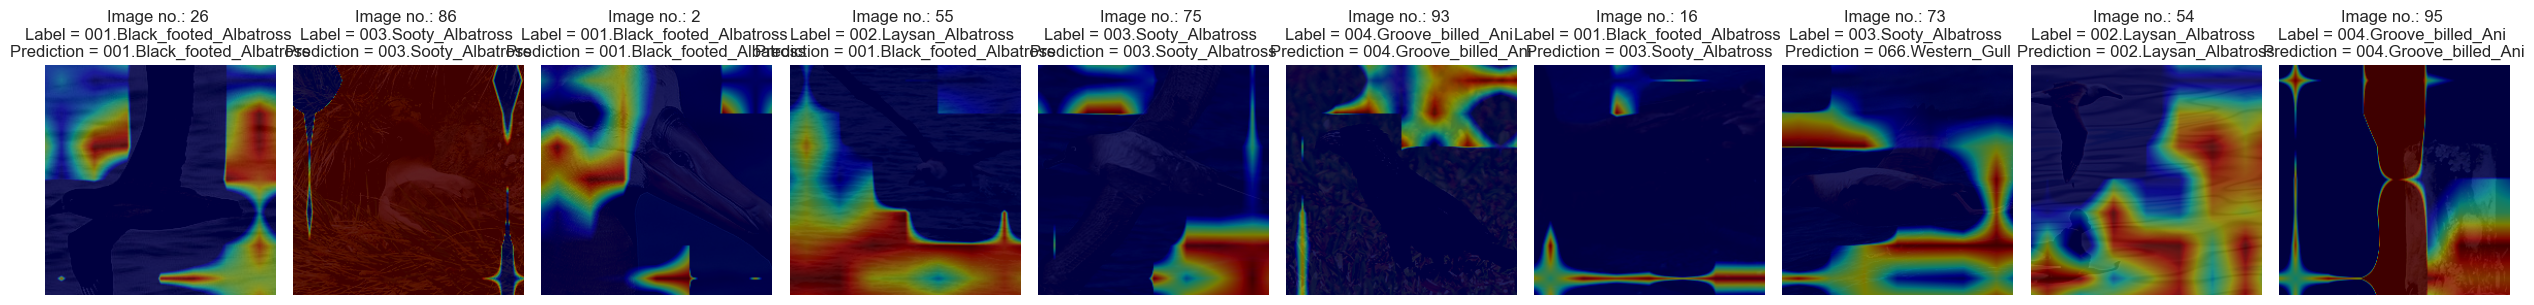

In [15]:
# Select image index to visualize
np.random.seed(0)
selected_idxs = np.random.choice(100, 10, replace=False)

# Construct "batch" for visualization
batch = {'image': [], 'label': [], 'concepts': [], 'index': []}
for i in selected_idxs:
    img, lab, concept = loaders['test'].dataset.__getitem__(i) #.values()
    batch['image'].append(img)
    batch['label'].append(lab)
    batch['concepts'].extend(concept)
    batch['index'].append(i)

# Stack data
batch['image'] = torch.stack(batch['image'])
batch['label'] = torch.tensor(batch['label']).reshape(-1, 1)

# Define target to compute loss wrt.
CAM_target = 'predictions'

# Compute saliency heatmaps
saliency_maps, predictions = compute_saliency_map(gcmodel, batch, criterion, CAM_target=CAM_target)

# Visualize saliency map
visualize_saliency_maps(saliency_maps, batch, predictions, normalization, CAM_target=CAM_target, figsize=(25, 10))
plt.tight_layout()
plt.show()

In [29]:
from tqdm.notebook import tqdm

train_imgs = [loaders['train'].dataset.__getitem__(i)[0] for i in tqdm(range(loaders['train'].dataset.__len__()))]

  0%|          | 0/4796 [00:00<?, ?it/s]

In [30]:
train_imgs_ = torch.stack(train_imgs)

In [34]:
train_imgs_.mean(axis=[0, 2, 3])


tensor([-0.0113, -0.0073, -0.0404])

### CAN'T GET THIS TO WORK SO I DID THE ABOVE INSTEAD - ALBERT

In [15]:
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

In [16]:
# # Define GradCAM model
# target_layers = [model.layer4[-1]]

# from torchvision.models import resnet18, resnet50, inception_v3
# from torchvision.models import ResNet18_Weights, ResNet50_Weights, Inception_V3_Weights

# model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)

# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())

In [17]:
# # Select random data point
# batch = next(iter(loaders['test']))

# # Define image and label
# input_tensor, labels = batch['image'], batch['label']
# input_tensor = input_tensor.to(device)
# input_tensor.requires_grad_()

# # GradCAM target
# targets = [ClassifierOutputTarget(281)] # for label in labels]
# targets = None

In [18]:
# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]

In [19]:
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from torchvision.models import resnet50

# model = resnet50(pretrained=True)
# target_layers = [model.layer4[-1]]
# input_tensor = # Create an input tensor image for your model..
# # Note: input_tensor can be a batch tensor with several images!

# # Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda)

# # You can also use it within a with statement, to make sure it is freed,
# # In case you need to re-create it inside an outer loop:
# # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
# #   ...

# # We have to specify the target we want to generate
# # the Class Activation Maps for.
# # If targets is None, the highest scoring category
# # will be used for every image in the batch.
# # Here we use ClassifierOutputTarget, but you can define your own custom targets
# # That are, for example, combinations of categories, or specific outputs in a non standard model.

# targets = [ClassifierOutputTarget(281)]

# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)